In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import integrate, stats
import matplotlib.cm as cm
from numpy import fft
from scipy import interpolate as intp


from source import plots
from source import prob_dists as pd
from source.utils import read_param_file, update_params


from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
param_file = './source/n0.params'
params = read_param_file(param_file)
p = params
p

{'R_G': 220,
 'd_solar': 8.5,
 'psi': 180,
 'M_min': 0.01,
 'M_max': 10000000000.0,
 'fwimp': 1.0,
 'mean_params': {'a': 77.4, 'b': 0.87, 'c': -0.23},
 'nside': 2048,
 'area_fermi': 2000.0,
 'n': 0,
 'log_flux_min': -15,
 'log_flux_max': -5,
 'N': 7500,
 'log_k_min': 3,
 'log_k_max': 9,
 'N_k': 100000,
 'psh_log_f_min': -8.5,
 'psh_log_f_max': -4.7,
 'N_psh': 1000,
 'omega_pixel': 2.4967135219492856e-07}

In [3]:
with np.load('./output/n0_pshfunc.npz') as f:
    psi = f['psi']
    fluxes = f['flux']
    psh2d = f['psh']

In [4]:
pshfunc2d = intp.interp2d(psi, fluxes, psh2d, bounds_error=False, fill_value=0)
fluxes = fluxes[10:-55]
np.log10(fluxes[-1])

-5.539357429718876

1.330966830124074e-07
1.1482808850456148e-07
9.655949399671555e-08
8.494457166401335e-08
7.416135835320412e-08
6.645230521478225e-08
5.962158355418532e-08
5.4340211906722294e-08
4.983351526582621e-08
4.614737486325097e-08
4.311767945133244e-08
4.053415075518505e-08
3.85083304537516e-08
3.672592528191651e-08
3.5430350369278075e-08
3.426201039807052e-08
3.353899272187105e-08
3.287047331265931e-08
3.2637940039349456e-08
3.240540676603959e-08


[Text(1, 0, '40.0'),
 Text(1, 0, '50.0'),
 Text(1, 0, '60.0'),
 Text(1, 0, '70.0'),
 Text(1, 0, '80.0'),
 Text(1, 0, '90.0'),
 Text(1, 0, '100.0'),
 Text(1, 0, '110.0'),
 Text(1, 0, '120.0'),
 Text(1, 0, '130.0'),
 Text(1, 0, '140.0'),
 Text(1, 0, '150.0'),
 Text(1, 0, '160.0'),
 Text(1, 0, '170.0'),
 Text(1, 0, '180.0')]

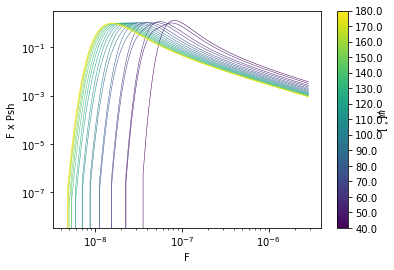

In [5]:
numnum = 20
psis = np.linspace(40, 180, num=numnum)
colors = cm.viridis(np.linspace(0, 1, num=numnum))

fig, ax = plt.subplots()

psh_vals_over_psi = []
fxs = fluxes
for psi, col in zip(psis, colors):
    ax.plot(fxs, fxs * pshfunc2d(psi, fxs).flatten(), label=rf"{psi}$^\circ$", color=col, lw=0.5)
    print(np.trapz(fxs * pshfunc2d(psi, fxs).flatten(), fxs))
   
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('F')
ax.set_ylabel('F x Psh')
cbarlabs = np.arange(min(psis), max(psis)+1, step=10)
cbar = fig.colorbar(cm.ScalarMappable(cmap=cm.viridis), ticks=np.linspace(0, 1, num=len(cbarlabs)))
cbar.set_label(r'$\psi$[$^\circ$]', rotation=270)
cbar.ax.set_yticklabels(cbarlabs)

In [7]:
counts = np.arange(0, 20)
exposure = 1 * 14000 * 0.2/0.5
psi = 40

In [8]:
from scipy.stats import poisson
print(poisson.pmf(counts[:, np.newaxis], exposure * fluxes).shape, pshfunc2d(40, fluxes).flatten().shape)

pcvals = np.trapz(pshfunc2d(psi, fluxes).flatten() * poisson.pmf(counts[:, np.newaxis], exposure * fluxes), fluxes, axis=-1)
# func = pshfunc2d(40, fluxes).flatten() * poisson.pmf(2, exposure * fluxes)
pcvals

(20, 185) (185,)


array([9.96977837e-01, 7.43925750e-04, 7.05649606e-07, 1.45355445e-09,
       3.67854973e-12, 8.74480816e-15, 1.86783892e-17, 3.57725123e-20,
       6.17962593e-23, 9.69991598e-26, 1.39335244e-28, 1.84356079e-31,
       2.25978913e-34, 2.57939050e-37, 2.75408209e-40, 2.76184913e-43,
       2.61066015e-46, 2.33361858e-49, 1.97833851e-52, 1.59479069e-55])

In [33]:
print(exposure*np.trapz(fluxes * pshfunc2d(40, fluxes).flatten(), fluxes))
pp = poisson.pmf(counts, exposure*np.trapz(fluxes * pshfunc2d(40, fluxes).flatten(), fluxes))

0.0007453414248694815


Text(0, 0.5, 'P(C) for 40 deg, n=0')

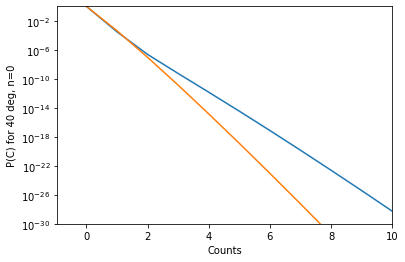

In [24]:
plt.plot(counts, pcvals)
plt.plot(counts, pp)
ax = plt.gca()

ax.set_yscale('log')
ax.set_ylim(top=1, bottom=1e-30)
ax.set_xlim(right=10)
ax.set_xlabel('Counts')
ax.set_ylabel('P(C) for 40 deg, n=0')

In [11]:
import healpy

In [12]:
nside = p['nside']
npix = healpy.nside2npix(nside)
pixel_counts = np.ones(npix) * healpy.pixelfunc.UNSEEN
print(npix)

50331648


In [21]:
lon, lat = healpy.pix2ang(nside, range(npix), lonlat=True)
ang_dists = np.rad2deg(np.arccos(np.cos(np.deg2rad(lon)) * np.cos(np.deg2rad(lat))))
ang_dists, lon, lat

(array([89.98384779, 90.01615221, 90.01615221, ..., 90.01615221,
        90.01615221, 89.98384779]),
 array([ 45., 135., 225., ..., 135., 225., 315.]),
 array([ 89.97715732,  89.97715732,  89.97715732, ..., -89.97715732,
        -89.97715732, -89.97715732]))

In [14]:
lon, lat, max(ang_dists), min(ang_dists)

(array([ 45., 135., 225., ..., 135., 225., 315.]),
 array([ 89.97715732,  89.97715732,  89.97715732, ..., -89.97715732,
        -89.97715732, -89.97715732]),
 179.98134902977873,
 0.018650970221280712)

(array([1.79981349e+02, 1.79978027e+02, 1.79956708e+02, ...,
        4.32924065e-02, 2.19726562e-02, 1.86509702e-02]),
 array([25157632, 25165823, 25149439, ..., 25145344, 25161728, 25153536]),
 22758552)

In [16]:
psis = np.linspace(40, 180, num=50)
pc_psi = np.array([np.trapz(pshfunc2d(abs(psi), fluxes).flatten() * poisson.pmf(counts[:, np.newaxis], exposure * fluxes), fluxes, axis=-1) for psi in psis])
pc_of_psi = intp.interp1d(psis, pc_psi, axis=0)

array([[9.97600463e-01, 6.05413322e-04, 5.41666769e-07, 1.14658997e-09,
        2.93230146e-12, 6.99298992e-15, 1.49576016e-17, 2.86694737e-20,
        4.95517815e-23, 7.78081957e-26, 1.11799002e-28, 1.47954165e-31,
        1.81389380e-34, 2.07072211e-37, 2.21122213e-40, 2.21767823e-43,
        2.09645721e-46, 1.87412182e-49, 1.58890135e-52, 1.28092945e-55],
       [9.98267446e-01, 4.51220723e-04, 3.71668028e-07, 8.21587909e-10,
        2.13129393e-12, 5.10427778e-15, 1.09383855e-17, 2.09885024e-20,
        3.63018528e-23, 5.70312332e-26, 8.19762616e-29, 1.08518510e-31,
        1.33072928e-34, 1.51943697e-37, 1.62279124e-40, 1.62775039e-43,
        1.53895565e-46, 1.37588532e-49, 1.16659575e-52, 9.40553188e-56],
       [9.97102362e-01, 7.16223264e-04, 6.72853038e-07, 1.39216155e-09,
        3.52930008e-12, 8.39444451e-15, 1.79342317e-17, 3.43519046e-20,
        5.93473637e-23, 9.31609670e-26, 1.33827996e-28, 1.77075696e-31,
        2.17061006e-34, 2.47765682e-37, 2.64551010e-40, 2.6530

In [18]:
good_indices = (abs(lat) >= 40)
subsample = ang_dists[good_indices]
print(len(subsample))
sub_counts = np.zeros(len(subsample))
for i, psi in enumerate(subsample):
    if i % 100000 == 0:
        print(i, '/', len(subsample))
#     print(psi)
    pcvals = pc_of_psi(abs(psi))
    sub_counts[i] = np.random.choice(np.arange(len(pcvals)), size=1, p=pcvals/np.sum(pcvals))
    
pixel_counts[good_indices] = sub_counts
pixel_counts_pc = pixel_counts[:]

17981440
0 / 17981440
100000 / 17981440
200000 / 17981440
300000 / 17981440
400000 / 17981440
500000 / 17981440
600000 / 17981440
700000 / 17981440
800000 / 17981440
900000 / 17981440
1000000 / 17981440
1100000 / 17981440
1200000 / 17981440
1300000 / 17981440
1400000 / 17981440
1500000 / 17981440
1600000 / 17981440
1700000 / 17981440
1800000 / 17981440
1900000 / 17981440
2000000 / 17981440
2100000 / 17981440
2200000 / 17981440
2300000 / 17981440
2400000 / 17981440
2500000 / 17981440
2600000 / 17981440
2700000 / 17981440
2800000 / 17981440
2900000 / 17981440
3000000 / 17981440
3100000 / 17981440
3200000 / 17981440
3300000 / 17981440
3400000 / 17981440
3500000 / 17981440
3600000 / 17981440
3700000 / 17981440
3800000 / 17981440
3900000 / 17981440
4000000 / 17981440
4100000 / 17981440
4200000 / 17981440
4300000 / 17981440
4400000 / 17981440
4500000 / 17981440
4600000 / 17981440
4700000 / 17981440
4800000 / 17981440
4900000 / 17981440
5000000 / 17981440
5100000 / 17981440
5200000 / 17981440

In [19]:
np.sum(pixel_counts > 0)

6236

0.8392936452111668


(0.0003469132616742597, 6238.0)

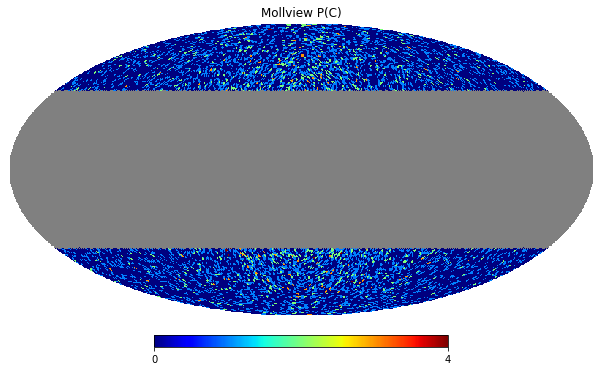

In [29]:
nreduce = 64
healpy.mollview(healpy.pixelfunc.ud_grade(healpy.pixelfunc.ma(pixel_counts_pc), nreduce, pess=True, power=-2), cmap=cm.jet, title="Mollview P(C)")
print(healpy.nside2pixarea(nreduce, degrees=True))
np.mean(pixel_counts_pc[good_indices]), np.sum(pixel_counts_pc[good_indices])

In [34]:
lsub = len(subsample)
pixel_counts_poisson = np.ones(npix) * healpy.pixelfunc.UNSEEN
sub_counts = np.zeros(lsub)
for i, psi in enumerate(subsample):
    if i % 100000 == 0:
        print(i, '/', lsub)
#     print(psi)
    sub_counts[i] = stats.poisson.rvs(exposure*np.trapz(fluxes * pshfunc2d(psi, fluxes).flatten(), fluxes))
    if sub_counts[i] > 5: 
        print(sub_counts[i])
    
pixel_counts_poisson[good_indices] = sub_counts


0 / 17981440
100000 / 17981440
200000 / 17981440
300000 / 17981440
400000 / 17981440
500000 / 17981440
600000 / 17981440
700000 / 17981440
800000 / 17981440
900000 / 17981440
1000000 / 17981440
1100000 / 17981440
1200000 / 17981440
1300000 / 17981440
1400000 / 17981440
1500000 / 17981440
1600000 / 17981440
1700000 / 17981440
1800000 / 17981440
1900000 / 17981440
2000000 / 17981440
2100000 / 17981440
2200000 / 17981440
2300000 / 17981440
2400000 / 17981440
2500000 / 17981440
2600000 / 17981440
2700000 / 17981440
2800000 / 17981440
2900000 / 17981440
3000000 / 17981440
3100000 / 17981440
3200000 / 17981440
3300000 / 17981440
3400000 / 17981440
3500000 / 17981440
3600000 / 17981440
3700000 / 17981440
3800000 / 17981440
3900000 / 17981440
4000000 / 17981440
4100000 / 17981440
4200000 / 17981440
4300000 / 17981440
4400000 / 17981440
4500000 / 17981440
4600000 / 17981440
4700000 / 17981440
4800000 / 17981440
4900000 / 17981440
5000000 / 17981440
5100000 / 17981440
5200000 / 17981440
5300000 

(0.00017084282460136675, 3072.0)

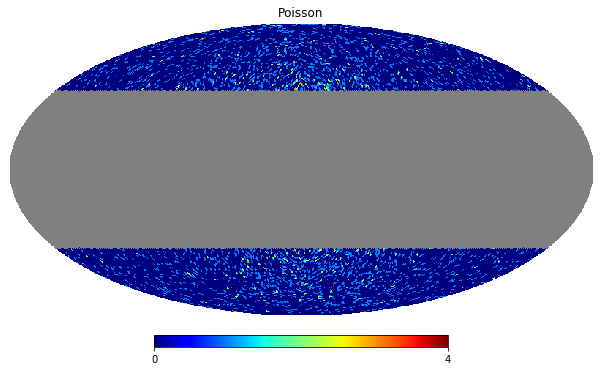

In [28]:
healpy.mollview(healpy.pixelfunc.ud_grade(healpy.pixelfunc.ma(pixel_counts_poisson), nreduce, pess=True, power=-2), cmap=cm.jet, title="Poisson")
np.mean(pixel_counts_poisson[good_indices]), np.sum(pixel_counts_poisson[good_indices])

In [ ]:
import scipy.stats as st

class my_pdf(st.rv_continuous):
    def _pdf(self, x):
        return custom_pdf(x)
    
    def _cdf(self, x):
        return custom_cdf(x)
    
    def _ppf(self, x):
        return custom_ppf(x)

In [ ]:
psi = 50
custom_pdf = lambda x: pshfunc2d(psi, x).flatten()

norm = np.trapz(pshfunc2d(psi, fluxes).flatten(), fluxes)
discrete_cdf = integrate.cumtrapz(pshfunc2d(psi, fluxes).flatten(), fluxes, initial=0)
custom_cdf = intp.interp1d(fluxes, discrete_cdf, fill_value=0, bounds_error=False)

custom_ppf = intp.interp1d(discrete_cdf, fluxes, fill_value=0, bounds_error=False)

func50 = my_pdf(a=fluxes.min(), b=fluxes.max(), name='my_pdf')

In [ ]:
# pcvals = np.trapz(pshfunc2d(psi, fluxes).flatten() * poisson.pmf(counts[:, np.newaxis], exposure * fluxes), fluxes, axis=-1)

def pc(psi, counts_max=15):
    counts = np.arange(0, counts_max + 1)
    
    pcvals = np.trapz(pshfunc2d(psi, fluxes).flatten() * poisson.pmf(counts[:, np.newaxis], exposure * fluxes), fluxes, axis=-1)
    custom_pdf = intp.interp1d(counts, pcvals, fill_value=0, bounds_error=False)
    
    discrete_cdf = integrate.cumtrapz(pcvals, counts, initial=0)
    custom_cdf = intp.interp1d(counts, discrete_cdf, fill_value=0, bounds_error=False)

    custom_ppf = intp.interp1d(discrete_cdf, counts, fill_value=0, bounds_error=False)
    
    return my_pdf(a=fluxes.min(), b=fluxes.max(), name='my_pdf')

In [ ]:
pc(50).rvs(size=10)

In [ ]:
psi = 40
pcvals = np.trapz(pshfunc2d(psi, fluxes).flatten() * poisson.pmf(counts[:, np.newaxis], exposure * fluxes), fluxes, axis=-1)
pp = poisson.pmf(counts, exposure*fluxes[np.argmax(pshfunc2d(psi, fluxes))])

print(np.sum(pcvals/np.sum(pcvals)))
plt.plot(counts, pcvals)
plt.plot(counts, pp)
plt.hist(np.random.choice(np.arange(len(pcvals)), size=100000, p=pcvals/np.sum(pcvals)))

ax = plt.gca()
ax.set_yscale('log')
# ax.set_ylim(top=1, bottom=1e-20)
ax.set_xlabel('Counts')
# ax.set_xscale('log')
ax.set_ylabel('P(C) for 40 deg, n=0')

In [ ]:
fig, ax = plt.subplots()
bins = np.logspace(np.log10(fluxes.min()), np.log10(fluxes.max()), num=50)
ax.hist(func50.rvs(size=100000), bins=bins)
ax.plot(fxs, fxs * pshfunc2d(psi, fxs).flatten(), label=rf"{psi}$^\circ$")
ax.set_xscale('log')
ax.set_yscale('log')

In [ ]:
for i, latt in enumerate(lat):
    if latt < 40:
        pixel_counts[i] = 0
    else:
        